In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
df=pd.read_csv('/content/gdrive/MyDrive/ECG/Matadata_ECG.csv')

In [ ]:
df

,Location,Labels
0,/ECG Dataset/ECG/Test/AF/0.png,1
1,/ECG Dataset/ECG/Train/SR/1.png,0
2,/ECG Dataset/ECG/Train/SR/2.png,0
3,/ECG Dataset/ECG/Train/AF/3.png,1
4,/ECG Dataset/ECG/Train/SR/4.png,0
...,...,...
3582,/ECG Dataset/ECG/Train/AF/3582.png,1
3583,/ECG Dataset/ECG/Train/SR/3583.png,0
3584,/ECG Dataset/ECG/Train/SR/3584.png,0
3585,/ECG Dataset/ECG/Test/AF/3585.png,1


In [ ]:
df.Labels.value_counts()

Labels
0    2000
1    1587
Name: count, dtype: int64

In [ ]:
import os

def count_images(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']
    image_count = 0
    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_count += 1
    return image_count

folder_path = '/content/gdrive/MyDrive/ECG/Test/SR'
num_images = count_images(folder_path)
print("SR folder:", num_images)

SR folder: 403


In [ ]:
folder_path = '/content/gdrive/MyDrive/ECG/Test/AF'
num_images = count_images(folder_path)
print("AF folder:", num_images)

AF folder: 315


In [ ]:
folder_path = '/content/gdrive/MyDrive/ECG/Train/SR'
num_images = count_images(folder_path)
print("SR folder:", num_images)

SR folder: 1597


In [ ]:
folder_path = '/content/gdrive/MyDrive/ECG/Train/AF'
num_images = count_images(folder_path)
print("AF folder:", num_images)

AF folder: 1272


In [ ]:
import tensorflow as tf

# defining the path
ds_trainn= tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/ECG/Train')
ds_testt= tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/ECG/Test')



Found 2869 files belonging to 2 classes.
Found 718 files belonging to 2 classes.


In [ ]:
# define the batch size and print the image labels
#dataset_name = dataset
#class_names = dataset.class_names
#print(class_names)

import tensorflow_datasets as tfds

batch_size = 32

size= (512, 512)
ds_train=ds_trainn.map(lambda image, label:(tf.image.resize(image, size), label))
ds_test=ds_testt.map(lambda image, label:(tf.image.resize(image, size), label))

Number of classes: 2
Number of training samples: 90
Number of validation samples: 23


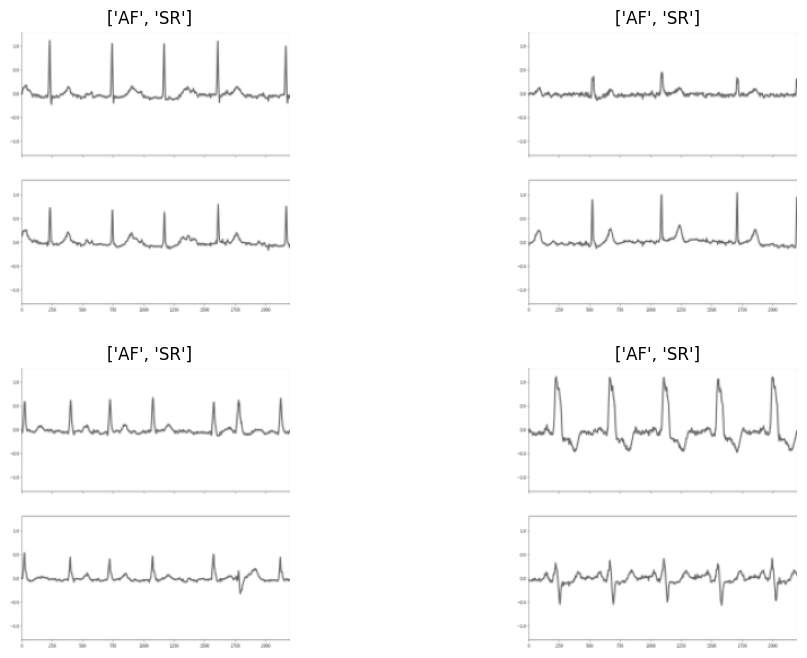

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get information about the dataset
num_classes = 2
num_train_samples = ds_trainn.cardinality().numpy()
num_test_samples = ds_testt.cardinality().numpy()
class_names=['AF', 'SR']

print("Number of classes:", num_classes)
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_test_samples)


plt.figure(figsize=(12, 8))
for images, labels in ds_trainn.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names)
        plt.axis("off")
plt.show()


# **1. Simple CNN**

In [ ]:
import tensorflow as tf
from keras import layers, models

model = models.Sequential()

# Convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display the model summary
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(ds_train, validation_data=ds_test, epochs=10)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(ds_test)
print("Validation Accuracy:", val_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

# **2.VGG16**

In [ ]:
import tensorflow as tf
from keras import layers, models

# Load the VGG16 model pre-trained on ImageNet
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(ds_train, validation_data=ds_test, epochs=100)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(ds_test)
print("Validation Accuracy:", val_acc)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21138500 (80.64 MB)
Trainable params: 6423812 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1

# **3.ResNet32**

In [ ]:
import tensorflow as tf
from keras import layers, models
from keras.applications import ResNet50

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model using the pre-trained ResNet50 as the base
model = models.Sequential()

# Add the ResNet50 base model
model.add(base_model)
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(ds_train, validation_data=ds_test, epochs=15)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(ds_test)
print("Validation Accuracy:", val_acc)

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 49278594 (187.98 MB)
Trainable params: 25690882 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
______

In [ ]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
print(configuration)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.40.0"
}



# **ViT (Visual Transformer)**

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ViTForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_folder_path = '/content/gdrive/MyDrive/ECG/Train'
test_folder_path = '/content/gdrive/MyDrive/ECG/Test'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class_names = ['SR', 'AF']

# Load datasets
train_dataset = datasets.ImageFolder(train_folder_path, transform=transform)
train_dataset.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

test_dataset = datasets.ImageFolder(test_folder_path, transform=transform)
test_dataset.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the ViT model and image processor
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Freeze the pre-trained model parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the classification head for the number of classes in the dataset
model.classifier = nn.Linear(model.config.hidden_size, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20, Train Loss: 0.6661, Train Accuracy: 0.6128, Test Accuracy: 0.7061
Epoch 2/20, Train Loss: 0.6042, Train Accuracy: 0.7198, Test Accuracy: 0.6852
Epoch 3/20, Train Loss: 0.5663, Train Accuracy: 0.7361, Test Accuracy: 0.7549
Epoch 4/20, Train Loss: 0.5326, Train Accuracy: 0.7745, Test Accuracy: 0.7827
Epoch 5/20, Train Loss: 0.5087, Train Accuracy: 0.7780, Test Accuracy: 0.7827
Epoch 6/20, Train Loss: 0.4894, Train Accuracy: 0.7947, Test Accuracy: 0.7813
Epoch 7/20, Train Loss: 0.4739, Train Accuracy: 0.7982, Test Accuracy: 0.7967
Epoch 8/20, Train Loss: 0.4605, Train Accuracy: 0.8041, Test Accuracy: 0.7841
Epoch 9/20, Train Loss: 0.4531, Train Accuracy: 0.8069, Test Accuracy: 0.7939
Epoch 10/20, Train Loss: 0.4415, Train Accuracy: 0.8135, Test Accuracy: 0.8022
Epoch 11/20, Train Loss: 0.4329, Train Accuracy: 0.8121, Test Accuracy: 0.7939
Epoch 12/20, Train Loss: 0.4291, Train Accuracy: 0.8149, Test Accuracy: 0.7994
Epoch 13/20, Train Loss: 0.4218, Train Accuracy: 0.8167, Test

# ***ARRAY FORM OF DATA***

In [ ]:
import numpy as np
# Load the data from Google Drive
y = np.load('/content/gdrive/MyDrive/arr2D_AF&SR_label.npy')
X = np.load('/content/gdrive/MyDrive/items_AF&SR.npy')

In [ ]:
import numpy as np

# Assuming arr is your (6428, 5000, 12) shaped array
arr = X
# Indices to remove from the third dimension
indices_to_remove = [2]  # 1st, 3rd, 7th, 8th positions

# Remove the specified positions from the third dimension
arr = np.delete(arr, indices_to_remove, axis=2)

# Now, the shape of arr will be (6428, 5000, 8)
print(arr.shape)

(3587, 1000, 2)


In [ ]:
#X = np.concatenate((s, a))
len(X)

3587

In [ ]:
#y = np.concatenate((sl, al))
len(y)

3587

In [ ]:
print(X.shape)
print(X)

(3587, 1000, 3)
[[[ 0.135 -0.125 -0.08 ]
  [ 0.135 -0.125 -0.08 ]
  [ 0.135 -0.125 -0.08 ]
  ...
  [-0.125 -0.066 -0.07 ]
  [-0.126 -0.063 -0.07 ]
  [-0.124 -0.06  -0.07 ]]

 [[-0.13  -0.045 -0.03 ]
  [-0.13  -0.045 -0.03 ]
  [-0.13  -0.045 -0.03 ]
  ...
  [ 0.003  0.027 -0.02 ]
  [ 0.005  0.025 -0.018]
  [ 0.005  0.024 -0.015]]

 [[-0.47  -0.43  -0.72 ]
  [-0.47  -0.43  -0.72 ]
  [-0.47  -0.43  -0.72 ]
  ...
  [-0.064  0.111  0.471]
  [-0.075  0.11   0.467]
  [-0.081  0.11   0.458]]

 ...

 [[ 0.025 -0.065  0.06 ]
  [ 0.025 -0.065  0.06 ]
  [ 0.025 -0.065  0.06 ]
  ...
  [-0.012 -0.035 -0.018]
  [-0.018 -0.006 -0.016]
  [-0.02   0.013 -0.021]]

 [[ 0.15   0.15   0.02 ]
  [ 0.15   0.15   0.02 ]
  [ 0.15   0.15   0.02 ]
  ...
  [ 0.121  0.05   0.063]
  [ 0.146  0.049  0.067]
  [ 0.166  0.052  0.071]]

 [[ 0.015  0.095 -0.005]
  [ 0.015  0.095 -0.005]
  [ 0.015  0.095 -0.005]
  ...
  [-0.102  0.113 -0.13 ]
  [-0.099  0.124 -0.129]
  [-0.1    0.125 -0.124]]]


In [ ]:
print(y.shape)
print(y)

(3587, 1)
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [ ]:
# Preprocessing
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

print(X_scaled)

[[[ 0.80705828 -0.4588596  -0.25228113]
  [ 0.80705828 -0.4588596  -0.25228113]
  [ 0.80705828 -0.4588596  -0.25228113]
  ...
  [-0.71186622 -0.24757386 -0.22215566]
  [-0.71770824 -0.23683052 -0.22215566]
  [-0.7060242  -0.22608717 -0.22215566]]

 [[-0.7410763  -0.17237046 -0.10165378]
  [-0.7410763  -0.17237046 -0.10165378]
  [-0.7410763  -0.17237046 -0.10165378]
  ...
  [ 0.035912    0.08546976 -0.07152831]
  [ 0.04759603  0.07830753 -0.06550321]
  [ 0.04759603  0.07472642 -0.05646557]]

 [[-2.72736219 -1.55109943 -2.18031125]
  [-2.72736219 -1.55109943 -2.18031125]
  [-2.72736219 -1.55109943 -2.18031125]
  ...
  [-0.35550316  0.38628336  1.4076323 ]
  [-0.41976535  0.38270224  1.39558212]
  [-0.45481746  0.38270224  1.36846919]]

 ...

 [[ 0.16443638 -0.24399274  0.16947546]
  [ 0.16443638 -0.24399274  0.16947546]
  [ 0.16443638 -0.24399274  0.16947546]
  ...
  [-0.05171826 -0.13655932 -0.06550321]
  [-0.08677037 -0.03270701 -0.05947812]
  [-0.0984544   0.03533416 -0.07454085]]

 [

# **Splitting the dataset** [taking every 5th index set as testing set]

In [ ]:
import numpy as np

# Assuming X and Y are your arrays
X_s = X_scaled
Y_s = y
# Generate indices for splitting
indices = np.arange(len(Y_s))

# Split the indices into train and test sets
test_indices = indices[::5]  # Every fifth index
train_indices = np.setdiff1d(indices, test_indices)

# Split X and Y using the generated indices
X_tr = X_s[train_indices]
Y_tr = Y_s[train_indices]

X_ts = X_s[test_indices]
Y_ts = Y_s[test_indices]

# Check the shapes
print("X_train shape:", X_tr.shape)
print("Y_train shape:", Y_tr.shape)
print("X_test shape:", X_ts.shape)
print("Y_test shape:", Y_ts.shape)

X_train shape: (2869, 1000, 3)
Y_train shape: (2869, 1)
X_test shape: (718, 1000, 3)
Y_test shape: (718, 1)


## **CNN-LSTM **

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten

# Define model parameters
num_classes = 2
input_shape = (1000, 3)  # assuming 1000 time steps and 12 leads

# Reshape the data to fit the CNN input shape
X_train_cnn = X_tr.reshape((-1, input_shape[0], input_shape[1]))  # reshape without channel dimension
X_test_cnn = X_ts.reshape((-1, input_shape[0], input_shape[1]))

# Define CNN-LSTM model architecture
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(X_train_cnn, Y_tr, epochs=80, batch_size=64, validation_split=0.1)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_ts, Y_ts)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 998, 64)           640       
                                                                 
 max_pooling1d (MaxPooling1  (None, 499, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 248, 128)          0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 248, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)               

# **CNN-Bi-LSTM **

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Bidirectional

# Define model parameters
num_classes = 2
input_shape = (1000, 3)  # assuming 1000 time steps and 3 features

# Reshape the data to fit the CNN input shape
X_train_cnn = X_tr.reshape((-1, input_shape[0], input_shape[1]))  # reshape without channel dimension
X_test_cnn = X_ts.reshape((-1, input_shape[0], input_shape[1]))

# Define CNN-Bi-LSTM model architecture
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(X_train_cnn, Y_tr, epochs=100, batch_size=64, validation_split=0.1)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_cnn, Y_ts)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 998, 64)           640       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 499, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 497, 128)          24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 248, 128)          0         
 g1D)                                                            
                                                                 
 bidirectional_2 (Bidirecti  (None, 248, 128)          98816     
 onal)                                                           
                                                      